In [1]:
# Imports (numpy, pandas, matplotlib, seaborn imported autom)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config

In [5]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)

In [6]:
eth_client.get_eth_last_price()

{'ethbtc': '0.07336',
 'ethbtc_timestamp': '1651073367',
 'ethusd': '2846.23',
 'ethusd_timestamp': '1651073369'}

# Nexus Tokenomics Investigation

## Current Bonding Curve Set-up

In [2]:
a = 0.01028
c = 5_800_000
mcr = 162_450
mcr_perc = 0.956

In [3]:
token_price = a + (mcr/c)*(mcr_perc**4)

In [4]:
token_price

0.033675013019826755

In [5]:
perc_range = np.linspace(0, 2, 21)

In [6]:
perc_range

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [7]:
token_price_range = a + (mcr/c)*(perc_range**4)

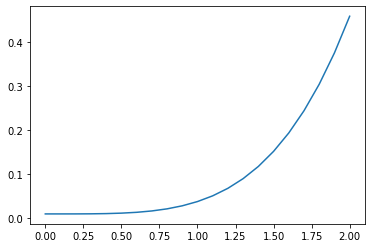

In [8]:
plt.plot(perc_range, token_price_range)

## New Version Testing

### Current wNXM price feed

In [2]:
url = 'https://api.coingecko.com/api/v3/simple/price'
params = {
        'ids':'wrapped-nxm',
        'vs_currencies': 'eth'
        }
current_wnxm_price_eth = requests.get(url, params=params).json()['wrapped-nxm']['eth']

In [3]:
current_wnxm_price_eth

0.00936202

### Weighted average days on covers 

In [35]:
### TODO: Provide live feed instead of just pulling in .csv
# https://github.com/rchen8/nexus-mutual-tracker

In [19]:
active_covers_expiration = pd.read_csv('../raw_data/active_cover_amount_by_expiration_date.csv')

In [20]:
active_covers_expiration.columns = ['exp_time', 'USD', 'ETH']

In [21]:
active_covers_expiration['exp_time'] = pd.to_datetime(active_covers_expiration['exp_time'])

In [22]:
active_covers_expiration.dtypes

exp_time    datetime64[ns]
USD                float64
ETH                float64
dtype: object

In [23]:
active_covers_expiration

,exp_time,USD,ETH
0,2022-04-25 18:10:27,3.994818e+08,139777.678632
1,2022-04-26 00:54:17,3.993961e+08,139747.678632
2,2022-04-26 01:52:07,3.993446e+08,139729.678632
3,2022-04-26 09:25:11,3.993418e+08,139728.678632
4,2022-04-26 09:34:52,3.991018e+08,139644.711634
...,...,...,...
816,2023-04-14 08:04:41,7.024883e+05,245.798900
817,2023-04-18 03:47:17,6.944891e+05,243.000000
818,2023-04-18 08:12:37,8.573940e+03,3.000000
819,2023-04-23 11:20:03,5.715960e+03,2.000000


In [24]:
active_covers_expiration['days_remaining'] = active_covers_expiration['exp_time']-pd.Timestamp.now().normalize()

In [25]:
active_covers_expiration['minutes_remaining'] = active_covers_expiration['days_remaining']/np.timedelta64(1, 'm')

In [26]:
((active_covers_expiration['ETH']*active_covers_expiration['minutes_remaining'])/active_covers_expiration['ETH'].sum()).sum()

84459.86370214474

In [27]:
# this needs an amplification factor
wavg_days = 82912/(24*60)

In [28]:
active_covers_expiration

,exp_time,USD,ETH,days_remaining,minutes_remaining
0,2022-04-25 18:10:27,3.994818e+08,139777.678632,0 days 18:10:27,1090.450000
1,2022-04-26 00:54:17,3.993961e+08,139747.678632,1 days 00:54:17,1494.283333
2,2022-04-26 01:52:07,3.993446e+08,139729.678632,1 days 01:52:07,1552.116667
3,2022-04-26 09:25:11,3.993418e+08,139728.678632,1 days 09:25:11,2005.183333
4,2022-04-26 09:34:52,3.991018e+08,139644.711634,1 days 09:34:52,2014.866667
...,...,...,...,...,...
816,2023-04-14 08:04:41,7.024883e+05,245.798900,354 days 08:04:41,510244.683333
817,2023-04-18 03:47:17,6.944891e+05,243.000000,358 days 03:47:17,515747.283333
818,2023-04-18 08:12:37,8.573940e+03,3.000000,358 days 08:12:37,516012.616667
819,2023-04-23 11:20:03,5.715960e+03,2.000000,363 days 11:20:03,523400.050000


### Calculating Exit Penalty

In [29]:
def exit_penalty(days_selected):
    if mcr_perc > 100:
        return 1
    else:
        return min(1, days_selected/wavg_days)

In [30]:
exit_penalty(30)

0.5210343496719414

### Pseudo-code for scenario testing

- WNXM price movements
- Crowd exits quickly/slowly/doesn't want to exit at all
    - 5/10/20/50/80% instant withdrawals?
- Time value: 5% / 10% / 20% / 50%